In [1]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.8.0
!pip install tensorflow_addons==0.16.1

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 36.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully

In [ ]:
!python train.py --model_id 1 --train_dir=/content/drive/MyDrive/plant/train --val_dir=/content/drive/MyDrive/plant/val

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, LeakyReLU, Flatten, MaxPooling2D, Input

# Util
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Train
# import argparse
# import tensorflow as tf
# import numpy as np
import matplotlib.pyplot as plt
# from utils import gen_maker, CustomCallback
# from networks import model_maker
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow_addons as tfa
import pickle as pkl

# eval
from tensorflow.keras.preprocessing import image
from tensorflow_addons.optimizers import AdamW


In [ ]:
# GPT CODE STARTS FOR OBJECT LOCALIZATION

In [ ]:
def localization_network(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    # Output layer to predict bounding box (4 values: x_min, y_min, x_max, y_max)
    bbox = layers.Dense(4, activation="sigmoid")(x)
    model = keras.Model(inputs, bbox, name="LocalizationNetwork")
    return model


In [ ]:
def create_vit_classifier_with_localization(input_shape, patch_size, num_patches, projection_dim, transformer_units,
                                            transformer_layers, model_name, num_heads, mlp_head_units, num_classes):
    # Localization network to predict bounding box
    localization_net = localization_network(input_shape)

    # Input for the original images
    inputs = layers.Input(shape=input_shape)
    # Predict bounding box
    bbox = localization_net(inputs)

    # Crop the image using the bounding box coordinates
    def crop_and_resize(image, bbox):
    # Unpack bbox coordinates
      x_min, y_min, x_max, y_max = tf.unstack(bbox, axis=-1)

      # Calculate offsets and target dimensions, applying per-batch processing
      offset_height = tf.cast(tf.round(y_min * tf.cast(tf.shape(image)[1], tf.float32)), tf.int32)
      offset_width = tf.cast(tf.round(x_min * tf.cast(tf.shape(image)[2], tf.float32)), tf.int32)
      target_height = tf.cast(tf.round((y_max - y_min) * tf.cast(tf.shape(image)[1], tf.float32)), tf.int32)
      target_width = tf.cast(tf.round((x_max - x_min) * tf.cast(tf.shape(image)[2], tf.float32)), tf.int32)

      # Ensure batch compatibility with offsets and target dimensions
      cropped_images = tf.map_fn(
          lambda img_and_box: tf.image.crop_to_bounding_box(
              img_and_box[0],
              img_and_box[1],
              img_and_box[2],
              img_and_box[3],
              img_and_box[4]
          ),
          elems=(image, offset_height, offset_width, target_height, target_width),
          dtype=image.dtype
      )

      return cropped_images


    localized_inputs = layers.Lambda(lambda x: crop_and_resize(x[0], x[1]))([inputs, bbox])

    # Pass the localized image into the ViT
    patches = Patches(patch_size)(localized_inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=logits, name=model_name)
    return model


In [8]:
# networks.py

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):  # Ensure kwargs is included here
        super(Patches, self).__init__(**kwargs)  # Pass kwargs to the parent class
        # super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    def get_config(self):
      # Add 'patch_size' to the layer config
      config = super().get_config()
      config.update({
          "patch_size": self.patch_size,
      })
      return config


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super(PatchEncoder, self).get_config()  # Call get_config from the parent class
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection.units,
        })
        return config


def create_vit_classifier(input_shape, patch_size, num_patches, projection_dim, transformer_units, transformer_layers, model_name, num_heads, mlp_head_units, num_classes):
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    #representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes, activation = 'softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits, name = model_name)
    return model

# def model_maker(target_size, model_id, num_classes = 3):
#     """ This function creates a trainable model.
#         params:
#             target_size: tuple, size of the input image to the network
#             model_id: integer, it can be 1 to 4
#         returns:
#             tensorflow trainable model.
#     """

#     if model_id == 1:
#         inp = Input(shape = (*target_size, 3), name = 'input_layer')
#         cnv1 = Conv2D(filters = 10, kernel_size = (3, 3), strides = (1, 1), name = 'conv_1')(inp)
#         cnv2 = Conv2D(filters = 10, kernel_size = (3, 3), strides = (1, 1), name = 'conv_2')(cnv1)
#         mxp1 = MaxPooling2D(pool_size = (2, 2), strides= (2, 2), name = 'maxpool_1')(cnv2)
#         cnv3 = Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), name = 'conv_3')(mxp1)
#         cnv4 = Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), name = 'conv_4')(cnv3)
#         mxp2 = MaxPooling2D(pool_size = (2, 2), strides= (2, 2), name = 'maxpool_2')(cnv4)
#         fltn = Flatten(name = 'flatten_layer')(mxp2)
#         FC1 = Dense(50, name = 'FC_1')(fltn)
#         FC1 = LeakyReLU(alpha = 0.3, name = 'leaky_ReLu_1')(FC1)
#         FC2 = Dense(50, name = 'FC_2')(FC1)
#         FC2 = LeakyReLU(alpha = 0.3, name = 'leaky_ReLu_2')(FC2)
#         output = Dense(num_classes, activation = 'softmax', name = 'output_layer')(FC2)
#         model = Model(inputs = inp, outputs = output, name = 'WheatClassifier_CNN_'+str(model_id))
#         model.summary()

#     if model_id == 2:
#         inp = Input(shape = (*target_size, 3), name = 'input_layer')
#         cnv1 = Conv2D(filters = 10, kernel_size = (3, 3), strides = (1, 1), name = 'conv_1')(inp)
#         cnv2 = Conv2D(filters = 10, kernel_size = (3, 3), strides = (1, 1), name = 'conv_2')(cnv1)
#         mxp1 = MaxPooling2D(pool_size = (2, 2), strides= (2, 2), name = 'maxpool_1')(cnv2)
#         cnv3 = Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), name = 'conv_3')(mxp1)
#         cnv4 = Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), name = 'conv_4')(cnv3)
#         mxp2 = MaxPooling2D(pool_size = (2, 2), strides= (2, 2), name = 'maxpool_2')(cnv4)
#         cnv5 = Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), name = 'conv_5')(mxp2)
#         cnv6 = Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), name = 'conv_6')(cnv5)
#         mxp3 = MaxPooling2D(pool_size = (2, 2), strides= (2, 2), name = 'maxpool_3')(cnv6)
#         fltn = Flatten(name = 'flatten_layer')(mxp3)
#         FC1 = Dense(50, name = 'FC_1')(fltn)
#         FC1 = LeakyReLU(alpha = 0.3, name = 'leaky_ReLu_1')(FC1)
#         FC2 = Dense(50, name = 'FC_2')(FC1)
#         FC2 = LeakyReLU(alpha = 0.3, name = 'leaky_ReLu_2')(FC2)
#         output = Dense(num_classes, activation = 'softmax', name = 'output_layer')(FC2)
#         model = Model(inputs = inp, outputs = output, name = 'WheatClassifier_CNN_'+str(model_id))
#         model.summary()

#     elif model_id == 3:
#         image_size = target_size[0]  # We'll resize input images to this size
#         patch_size = 10  # Size of the patches to be extract from the input images
#         num_patches = (image_size // patch_size) ** 2
#         projection_dim = 64
#         num_heads = 4
#         transformer_units = [
#             projection_dim * 2,
#             projection_dim]  # Size of the transformer layers
#         transformer_layers = 2
#         mlp_head_units = [50, 50]
#         model = create_vit_classifier((*target_size, 3),
#                                       patch_size,
#                                       num_patches,
#                                       projection_dim,
#                                       transformer_units,
#                                       transformer_layers,
#                                       'WheatClassifier_VIT_'+str(model_id),
#                                       num_heads, mlp_head_units, num_classes)
#         model.summary()

#     elif model_id == 4:
#         image_size = target_size[0]  # We'll resize input images to this size
#         patch_size = 10  # Size of the patches to be extract from the input images
#         num_patches = (image_size // patch_size) ** 2
#         projection_dim = 64
#         num_heads = 4
#         transformer_units = [
#             projection_dim * 2,
#             projection_dim]  # Size of the transformer layers
#         transformer_layers = 4
#         mlp_head_units = [50, 50]
#         model = create_vit_classifier((*target_size, 3),
#                                       patch_size,
#                                       num_patches,
#                                       projection_dim,
#                                       transformer_units,
#                                       transformer_layers,
#                                       'WheatClassifier_VIT_'+str(model_id),
#                                       num_heads, mlp_head_units, num_classes)

#         model.summary()

#     elif model_id == 5:
#         inp = Input(shape = (*target_size, 3), name = 'input_layer')
#         cnv1 = Conv2D(filters = 10, kernel_size = (3, 3), strides = (1, 1), name = 'conv_1')(inp)
#         cnv2 = Conv2D(filters = 10, kernel_size = (3, 3), strides = (1, 1), name = 'conv_2')(cnv1)
#         mxp1 = MaxPooling2D(pool_size = (2, 2), strides= (2, 2), name = 'maxpool_1')(cnv2)
#         size_mxp1 = getattr(mxp1, 'shape')
#         image_size =size_mxp1[1]  # We'll resize input images to this size
#         patch_size = 10  # Size of the patches to be extract from the input images
#         num_patches = (image_size // patch_size) ** 2
#         projection_dim = 64
#         num_heads = 4
#         transformer_units = [
#             projection_dim * 2,
#             projection_dim]  # Size of the transformer layers
#         transformer_layers = 1
#         mlp_head_units = [50, 50]
#         patches = Patches(patch_size)(mxp1)
#         # Encode patches.
#         encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

#         # Create multiple layers of the Transformer block.
#         for _ in range(transformer_layers):
#             # Layer normalization 1.
#             x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
#             # Create a multi-head attention layer.
#             attention_output = layers.MultiHeadAttention(
#                 num_heads=num_heads, key_dim=projection_dim, dropout=0.1
#             )(x1, x1)
#             # Skip connection 1.
#             x2 = layers.Add()([attention_output, encoded_patches])
#             # Layer normalization 2.
#             x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
#             # MLP.
#             x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
#             # Skip connection 2.
#             encoded_patches = layers.Add()([x3, x2])

#         # Create a [batch_size, projection_dim] tensor.
#         representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

#         fltn = Flatten(name = 'flatten_layer')(representation)
#         FC1 = Dense(50, name = 'FC_1')(fltn)
#         FC1 = LeakyReLU(alpha = 0.3, name = 'leaky_ReLu_1')(FC1)
#         FC2 = Dense(50, name = 'FC_2')(FC1)
#         FC2 = LeakyReLU(alpha = 0.3, name = 'leaky_ReLu_2')(FC2)
#         output = Dense(num_classes, activation = 'softmax', name = 'output_layer')(FC2)
#         model = Model(inputs = inp, outputs = output, name = 'WheatClassifier_CNN_'+str(model_id))
#         model.summary()

#     elif model_id == 6:
#         inp = Input(shape = (*target_size, 3), name = 'input_layer')
#         cnv1 = Conv2D(filters = 10, kernel_size = (3, 3), strides = (1, 1), name = 'conv_1')(inp)
#         cnv2 = Conv2D(filters = 10, kernel_size = (3, 3), strides = (1, 1), name = 'conv_2')(cnv1)
#         mxp1 = MaxPooling2D(pool_size = (2, 2), strides= (2, 2), name = 'maxpool_1')(cnv2)
#         cnv3 = Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), name = 'conv_3')(mxp1)
#         cnv4 = Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), name = 'conv_4')(cnv3)
#         mxp2 = MaxPooling2D(pool_size = (2, 2), strides= (2, 2), name = 'maxpool_2')(cnv4)
#         size_mxp2 = getattr(mxp2, 'shape')
#         image_size =size_mxp2[1]  # We'll resize input images to this size
#         patch_size = 5  # Size of the patches to be extract from the input images
#         num_patches = (image_size // patch_size) ** 2
#         print(num_patches, patch_size, image_size)
#         projection_dim = 64
#         num_heads = 4
#         transformer_units = [
#           projection_dim * 2,
#           projection_dim]  # Size of the transformer layers
#         transformer_layers = 2
#         mlp_head_units = [50, 50]
#         patches = Patches(patch_size)(mxp2)
#       # Encode patches.
#         encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

#       # Create multiple layers of the Transformer block.
#         for _ in range(transformer_layers):
#           # Layer normalization 1.
#             x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
#           # Create a multi-head attention layer.
#             attention_output = layers.MultiHeadAttention(
#               num_heads=num_heads, key_dim=projection_dim, dropout=0.1
#             )(x1, x1)
#           # Skip connection 1.
#             x2 = layers.Add()([attention_output, encoded_patches])
#           # Layer normalization 2.
#             x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
#           # MLP.
#             x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
#           # Skip connection 2.
#             encoded_patches = layers.Add()([x3, x2])

#       # Create a [batch_size, projection_dim] tensor.
#         representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

#         fltn = Flatten(name = 'flatten_layer')(representation)
#         FC1 = Dense(50, name = 'FC_1')(fltn)
#         FC1 = LeakyReLU(alpha = 0.3, name = 'leaky_ReLu_1')(FC1)
#         FC2 = Dense(50, name = 'FC_2')(FC1)
#         FC2 = LeakyReLU(alpha = 0.3, name = 'leaky_ReLu_2')(FC2)
#         output = Dense(num_classes, activation = 'softmax', name = 'output_layer')(FC2)
#         model = Model(inputs = inp, outputs = output, name = 'WheatClassifier_CNN-VIT_'+str(model_id))
#         model.summary()

#     elif model_id == 7:
#         image_size = target_size[0]  # We'll resize input images to this size
#         patch_size = 10  # Size of the patches to be extract from the input images
#         num_patches = (image_size // patch_size) ** 2
#         projection_dim = 64
#         num_heads = 4
#         transformer_units = [
#           projection_dim * 2,
#           projection_dim]  # Size of the transformer layers
#         transformer_layers = 1
#         mlp_head_units = [50, 50]
#         inputs = layers.Input(shape = (*target_size, 3), name = 'input_layer')
#       # Create patches.
#         patches = Patches(patch_size)(inputs)

#       # Encode patches.
#         encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

#       # Create multiple layers of the Transformer block.
#         for _ in range(transformer_layers):
#           # Layer normalization 1.
#             x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
#           # Create a multi-head attention layer.
#             attention_output = layers.MultiHeadAttention(
#               num_heads=num_heads, key_dim=projection_dim, dropout=0.1
#           )(x1, x1)
#           # Skip connection 1.
#             x2 = layers.Add()([attention_output, encoded_patches])
#           # Layer normalization 2.
#             x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
#           # MLP.
#             x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
#           # Skip connection 2.
#             encoded_patches = layers.Add()([x3, x2])

#       # Create a [batch_size, projection_dim] tensor.
#         representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
#         size_rep = getattr(representation, 'shape')

#         representation = tf.keras.layers.Reshape((int(size_rep[1]**0.5), int(size_rep[1]**0.5), size_rep[2]))(representation)
#         cnv1 = Conv2D(filters = 10, kernel_size = (3, 3), strides = (1, 1), name = 'conv_1')(representation)
#         cnv2 = Conv2D(filters = 10, kernel_size = (3, 3), strides = (1, 1), name = 'conv_2')(cnv1)
#         if int(size_rep[1]**0.5)>5:
#             mxp1 = MaxPooling2D(pool_size = (2, 2), strides= (2, 2), name = 'maxpool_1')(cnv2)

#             fltn = Flatten(name = 'flatten_layer')(mxp1)
#         else:
#             fltn = Flatten(name = 'flatten_layer')(cnv2)
#         FC1 = Dense(50, name = 'FC_1')(fltn)
#         FC1 = LeakyReLU(alpha = 0.3, name = 'leaky_ReLu_1')(FC1)
#         FC2 = Dense(50, name = 'FC_2')(FC1)
#         FC2 = LeakyReLU(alpha = 0.3, name = 'leaky_ReLu_2')(FC2)
#         output = Dense(num_classes, activation = 'softmax', name = 'output_layer')(FC2)
#         model = Model(inputs = inputs, outputs = output, name = 'WheatClassifier_CNN_'+str(1))
#         model.summary()

#     elif model_id == 8:
#         image_size = target_size[0]  # We'll resize input images to this size
#         patch_size = 10  # Size of the patches to be extract from the input images
#         num_patches = (image_size // patch_size) ** 2
#         projection_dim = 64
#         num_heads = 4
#         transformer_units = [
#           projection_dim * 2,
#           projection_dim]  # Size of the transformer layers
#         transformer_layers = 2
#         mlp_head_units = [50, 50]
#         inputs = layers.Input(shape = (*target_size, 3), name = 'input_layer')
#       # Create patches.
#         patches = Patches(patch_size)(inputs)

#       # Encode patches.
#         encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

#       # Create multiple layers of the Transformer block.
#         for _ in range(transformer_layers):
#           # Layer normalization 1.
#             x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
#           # Create a multi-head attention layer.
#             attention_output = layers.MultiHeadAttention(
#               num_heads=num_heads, key_dim=projection_dim, dropout=0.1
#             )(x1, x1)
#           # Skip connection 1.
#             x2 = layers.Add()([attention_output, encoded_patches])
#           # Layer normalization 2.
#             x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
#           # MLP.
#             x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
#           # Skip connection 2.
#             encoded_patches = layers.Add()([x3, x2])

#       # Create a [batch_size, projection_dim] tensor.
#         representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
#         size_rep = getattr(representation, 'shape')

#         representation = tf.keras.layers.Reshape((int(size_rep[1]**0.5), int(size_rep[1]**0.5), size_rep[2]))(representation)
#         if int(size_rep[1]**0.5)==5:
#             cnv1 = Conv2D(filters = 10, kernel_size = (3, 3), strides = (1, 1), name = 'conv_1', padding = 'same')(representation)
#             cnv2 = Conv2D(filters = 10, kernel_size = (3, 3), strides = (1, 1), name = 'conv_2', padding = 'same')(cnv1)
#             #mxp1 = MaxPooling2D(pool_size = (2, 2), strides= (2, 2), name = 'maxpool_1')(cnv2)

#             cnv3 = Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), name = 'conv_3', padding = 'valid')(cnv2)
#             cnv4 = Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), name = 'conv_4', padding = 'valid')(cnv3)
#             #mxp2 = MaxPooling2D(pool_size = (2, 2), strides= (2, 2), name = 'maxpool_2')(cnv4)


#             fltn = Flatten(name = 'flatten_layer')(cnv4)
#         elif int(size_rep[1]**0.5)==10:
#             cnv1 = Conv2D(filters = 10, kernel_size = (3, 3), strides = (1, 1), name = 'conv_1', padding = 'valid')(representation)
#             cnv2 = Conv2D(filters = 10, kernel_size = (3, 3), strides = (1, 1), name = 'conv_2', padding = 'valid')(cnv1)
#             #mxp1 = MaxPooling2D(pool_size = (2, 2), strides= (2, 2), name = 'maxpool_1')(cnv2)

#             cnv3 = Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), name = 'conv_3', padding = 'valid')(cnv2)
#             cnv4 = Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), name = 'conv_4', padding = 'valid')(cnv3)
#             #mxp2 = MaxPooling2D(pool_size = (2, 2), strides= (2, 2), name = 'maxpool_2')(cnv4)


#             fltn = Flatten(name = 'flatten_layer')(cnv4)
#         else:
#             cnv1 = Conv2D(filters = 10, kernel_size = (3, 3), strides = (1, 1), name = 'conv_1', padding = 'valid')(representation)
#             cnv2 = Conv2D(filters = 10, kernel_size = (3, 3), strides = (1, 1), name = 'conv_2', padding = 'valid')(cnv1)
#             mxp1 = MaxPooling2D(pool_size = (2, 2), strides= (2, 2), name = 'maxpool_1')(cnv2)

#             cnv3 = Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), name = 'conv_3', padding = 'valid')(mxp1)
#             cnv4 = Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), name = 'conv_4', padding = 'valid')(cnv3)
#             mxp2 = MaxPooling2D(pool_size = (2, 2), strides= (2, 2), name = 'maxpool_2')(cnv4)


#             fltn = Flatten(name = 'flatten_layer')(mxp2)

#         FC1 = Dense(50, name = 'FC_1')(fltn)
#         FC1 = LeakyReLU(alpha = 0.3, name = 'leaky_ReLu_1')(FC1)
#         FC2 = Dense(50, name = 'FC_2')(FC1)
#         FC2 = LeakyReLU(alpha = 0.3, name = 'leaky_ReLu_2')(FC2)
#         output = Dense(num_classes, activation = 'softmax', name = 'output_layer')(FC2)
#         model = Model(inputs = inputs, outputs = output, name = 'WheatClassifier_CNN_'+str(1))
#         model.summary()




#     return model
def model_maker(target_size, model_id, num_classes=3):
    image_size = target_size[0]
    patch_size = 10
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [projection_dim * 2, projection_dim]
    transformer_layers = 2
    mlp_head_units = [50, 50]

    model = create_vit_classifier_with_localization(
        (*target_size, 3), patch_size, num_patches, projection_dim, transformer_units,
        transformer_layers, 'WheatClassifier_VIT_' + str(model_id), num_heads, mlp_head_units, num_classes
    )
    model.summary()
    return model


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
def gen_maker(train_path, val_path, target_size=(100, 100), batch_size=16, mode='categorical'):
    """
    This function creates data generators for train and validation data.
    params:
        train_path: path to the training data folder, string.
        val_path: path to the validation data folder, string.
        target_size: size of the inputs to the network, tuple.
        batch_size: the batch size for training and validation, integer.
        mode: classification mode, it can be either "binary" or "categorical"
    returns:
        train_generator: data generator for training data.
        validation_generator: data generator for validation data.
    """

    train_datagen = ImageDataGenerator( rotation_range=10,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    channel_shift_range=0.0,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    rescale=1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=mode)

    validation_generator = test_datagen.flow_from_directory(
        val_path,
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode=mode)
    return train_generator, validation_generator

class CustomCallback(tf.keras.callbacks.Callback):
    """
    This callback saves the model at the end of each epoch and calculates
    the confusion matrix and classification report on the validation data.
    """

    def __init__(self, val_gen, model_path, model_id):

        super(CustomCallback, self).__init__()
        self.val_gen = val_gen
        self.model_path = model_path
        self.model_id = model_id

    def on_epoch_end(self, epoch, logs=None):
        self.model.save(self.model_path + 'epoch{}-id{}'.format(epoch,self.model_id ))
        y_pred = self.model.predict(self.val_gen)
        y_pred = np.squeeze(np.argmax(y_pred, axis = 1))
        y_true = self.val_gen.classes
        cnf = confusion_matrix(y_true, y_pred)
        cls_report = classification_report(y_true, y_pred)
        print('\nclassification report:\n', cls_report)
        print('\nconfusion matrix:\n', cnf)


In [ ]:
epochs = 1                # Number of total epochs
init_epoch = 0              # Initial epoch
train_dir = '/content/train/'  # Training data folder path
val_dir = '/content/val/'      # Validation data folder path
model_id = 3               # Model ID: it can be 1, 2, 3, or 4
load_model = 0              # If 1, load a previously trained model
load_path = None            # Path to the pre-trained model
backup_path = '/content/'   # Path to store the model
batch_size = 16             # Batch size for training
mode = 'categorical'        # Classification mode
target_size = 100           # Size of the input images

train_dir = '/content/drive/MyDrive/plant/train'
val_dir = '/content/drive/MyDrive/plant/val'

# Define the main training function
def main():

    # Generate training and validation datasets
    train_gen, val_gen = gen_maker(
        train_dir,
        val_dir,
        target_size=(target_size, target_size),
        batch_size=batch_size,
        mode=mode
    )

    # Custom callback
    clbk = CustomCallback(val_gen, backup_path, model_id)

    # Set learning rate and weight decay
    learning_rate = 0.001
    weight_decay = 0.0001

    # Create the model
    model = model_maker((target_size, target_size), model_id)

    # Set up optimizer
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=weight_decay
    )

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=categorical_crossentropy,
        metrics=['acc']
    )

    # Load pre-trained model if specified
    if load_model:
        model = tf.keras.models.load_model(load_path)

    # Train the model
    results = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=[clbk],
        initial_epoch=init_epoch
    )

    # Predict validation data
    y_pred_valid = model.predict(val_gen)

    # Save history and model
    history = {
        'train loss': results.history['loss'],
        'val loss': results.history['val_loss'],
        'train acc': results.history['acc'],
        'val acc': results.history['val_acc'],
        'y_true_valid': val_gen.classes,
        'y_pred_valid': y_pred_valid,
        'id': model_id
    }
    model.save(f"{backup_path}model.h5")

    with open(f"{backup_path}history-id-{model_id}.pkl", 'wb') as f:
        pkl.dump(history, f)

    # Plot training and validation metrics
    plt.subplots(figsize=(15, 15))
    plt.subplot(2, 1, 1)
    plt.plot(results.history['loss'], '-', color=[0, 0, 1, 1])
    plt.plot(results.history['val_loss'], '-', color=[1, 0, 0, 1])
    plt.legend(['train loss', 'val loss'])

    plt.subplot(2, 1, 2)
    plt.plot([0, *results.history['acc']], '-', color=[0, 0, 1, 1])
    plt.plot([0, *results.history['val_acc']], '-', color=[1, 0, 0, 1])
    plt.legend(['train acc', 'val acc'])

    plt.savefig(f"{backup_path}charts.png")

# Run main function
main()

Found 2942 images belonging to 3 classes.
Found 737 images belonging to 3 classes.


Instructions for updating:
Use fn_output_signature instead


Model: "WheatClassifier_VIT_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 LocalizationNetwork (Functiona  (None, 4)           4353604     ['input_6[0][0]']                
 l)                                                                                               
                                                                                                  
 lambda_2 (Lambda)              (None, None, None,   0           ['input_6[0][0]',                
                                3)                                'Localizatio

InvalidArgumentError: Graph execution error:

Detected at node 'WheatClassifier_VIT_3/lambda_2/map/while/crop_to_bounding_box/Assert_2/Assert' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
      ColabKernelApp.launch_instance()
    File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
      ret = callback()
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
      self.ctx_run(self.run)
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
      yielded = self.gen.send(value)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
      self.do_execute(
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-16-a6d5bf3f7ef9>", line 97, in <cell line: 97>
      main()
    File "<ipython-input-16-a6d5bf3f7ef9>", line 56, in main
      results = model.fit(
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/layers/core/lambda_layer.py", line 196, in call
      result = self.function(inputs, **kwargs)
    File "<ipython-input-13-deba9ae5aa18>", line 38, in <lambda>
      localized_inputs = layers.Lambda(lambda x: crop_and_resize(x[0], x[1]))([inputs, bbox])
    File "<ipython-input-13-deba9ae5aa18>", line 23, in crop_and_resize
      cropped_images = tf.map_fn(
    File "<ipython-input-13-deba9ae5aa18>", line 24, in 
      lambda img_and_box: tf.image.crop_to_bounding_box(
    File "<ipython-input-13-deba9ae5aa18>", line 24, in 
      lambda img_and_box: tf.image.crop_to_bounding_box(
Node: 'WheatClassifier_VIT_3/lambda_2/map/while/crop_to_bounding_box/Assert_2/Assert'
assertion failed: [target_width must be > 0.]
	 [[{{node WheatClassifier_VIT_3/lambda_2/map/while/crop_to_bounding_box/Assert_2/Assert}}]] [Op:__inference_train_function_5792]

In [ ]:
# EVALUATE THE MODEL --DONT USE THIS FOR MODEL 3,4 CHANGED CODE

# Load the model with the custom optimizer specified
model = tf.keras.models.load_model('/content/model.h5', custom_objects={'AdamW': AdamW})

# Load and preprocess a single image
img_path = '/content/drive/MyDrive/plant/val/Brown_rust/Brown_rust036.jpg'
img = image.load_img(img_path, target_size=(100, 100))  # Resize as per model input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize if necessary

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

print("Predicted class:", predicted_class)



ValueError: Unknown layer: Patches. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [11]:
# Load the model with the custom optimizer and custom layer specified
# Load the model with the custom optimizer and custom layers specified
model = tf.keras.models.load_model(
    '/content/model.h5',
    custom_objects={
        'AdamW': AdamW,
        'Patches': Patches,
        'PatchEncoder': PatchEncoder  # Add PatchEncoder here
    }
)


# Load and preprocess a single image
img_path = '/content/drive/MyDrive/plant/val/Brown_rust/Brown_rust036.jpg'
img_path = '/content/drive/MyDrive/plant/val/Yellow_rust/Yellow_rust486.jpg'
img_path = '/content/drive/MyDrive/plant/val/Healthy/Healthy1030.jpg'
img = image.load_img(img_path, target_size=(100, 100))  # Resize as per model input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize if necessary

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

print("Predicted class:", predicted_class)


Predicted class: [1]


In [ ]:
!python try.py

2024-10-30 16:50:36.770680: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
Found 2942 images belonging to 3 classes.
Found 737 images belonging to 3 classes.
2024-10-30 16:50:41.270187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-10-30 16:50:41.270235: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
Model: "WheatClassifier_CNN_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 100, 3)] 

In [ ]:
# WARNING:tensorflow:5 out of the last 98 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ef1d5c2dab0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
# Predicted class: [2]

In [ ]:
!python plantdisease\ gpt.py

2024-11-03 17:35:00.147342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
Found 2942 images belonging to 3 classes.
Found 737 images belonging to 3 classes.
2024-11-03 17:35:06.201928: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-11-03 17:35:06.201998: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
Model: "WheatClassifier_VIT_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to       

In [ ]:
#changed the model_maker from GPT

In [4]:
!python pd\ transformer\ fix\ for\ gpt.py

2024-11-05 16:38:47.173569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-11-05 16:38:47.173613: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Found 2942 images belonging to 3 classes.
Found 737 images belonging to 3 classes.
2024-11-05 16:38:51.786354: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-11-05 16:38:51.786417: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-11-05 16:38:51.786446: I tensorflow/stream_executor

In [ ]:
# 05 - 11 - OBJECT bounding box from GPT

In [15]:
!python 02fix\ from\ gpt.py

2024-11-05 17:24:53.472065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
Found 2942 images belonging to 3 classes.
Found 737 images belonging to 3 classes.
2024-11-05 17:24:58.314537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-11-05 17:24:58.314583: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
Model: "WheatClassifier_VIT_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to       

In [17]:
!python 03claudetry1.py

2024-11-05 17:33:07.824753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
Found 2942 images belonging to 3 classes.
Found 737 images belonging to 3 classes.
2024-11-05 17:33:12.370068: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-11-05 17:33:12.370113: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
Model: "PlantDiseaseClassifier_VIT_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to

In [21]:
!python 03claudetry1.py

2024-11-05 17:54:18.549596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
Found 2942 images belonging to 3 classes.
Found 737 images belonging to 3 classes.
2024-11-05 17:54:24.900677: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-11-05 17:54:24.900725: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
Model: "PlantDiseaseClassifier_VIT_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to

In [35]:
model = tf.keras.models.load_model(
    '/content/model.h5',
    custom_objects={
        'AdamW': AdamW,
        'Patches': Patches,
        'PatchEncoder': PatchEncoder  # Add PatchEncoder here
    }
)

img_path = '/content/drive/MyDrive/plant/val/Healthy/Healthy1030.jpg'
img_path = '/content/drive/MyDrive/plant/val/Yellow_rust/Yellow_rust486.jpg'
img_path = '/content/drive/MyDrive/plant/val/Brown_rust/Brown_rust036.jpg'
img = image.load_img(img_path, target_size=(100, 100))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

class_preds, loc_preds = model.predict(img_array)
print("Predicted class:", np.argmax(class_preds))
print("Localization prediction:", loc_preds[0][0])

Predicted class: 0
Localization prediction: 0.35717332


[35.71733236312866, 35.71733236312866, 35.71733236312866, 35.71733236312866]
35 35 35 35 0.8121615 Disease


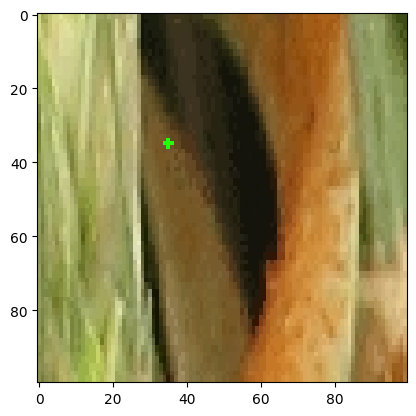

In [36]:
import cv2
def draw_bounding_boxes(image, boxes, scores, labels):
    """
    Draw bounding boxes on the given image.
    """
    img = image.copy()
    # for box, score, label in zip(boxes, scores, labels):
    #     print(box)
    #     x1, y1, x2, y2 = [int(x) for x in box]
    #     cv2.rectangle(img, (x1, y1), (x2, y2), (36, 255, 12), 2)
    #     cv2.putText(img, f"{label}: {score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36, 255, 12), 2)
    # make boxes as int array
    boxes = np.array(boxes).astype(int)
    x1 = boxes[0]
    y1 = boxes[1]
    x2 = boxes[2]
    y2 = boxes[3]
    score = scores[0]
    label = labels[0]
    print(x1, y1, x2, y2, score, label)
    cv2.rectangle(img, (x1, y1), (x2, y2), (36, 255, 12), 2)
    # cv2.putText(img, f"{label}: {score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36, 255, 12), 2)
    return img
boxes = loc_preds[0] * [100, 100, 100, 100]  # Rescale the bounding box coordinates
boxes = [b for b in boxes]
print(boxes)
labels = ['Disease']
scores = [class_preds[0, np.argmax(class_preds)]]
# convert img to numpy array
img = np.array(img)
img_with_boxes = draw_bounding_boxes(img, boxes, scores, labels)
plt.imshow(img_with_boxes)
plt.show()